# Intro: Music segmentation

Let $X \in \mathbb{R}^{d\times t}$ denote a time series of feature data, where $d$ denotes the dimension of features, and $t$ is a time index at some fixed resolution (say, 10Hz).  Existing approaches to music segmentation suppose that there is a single partitioning into $m$ temporally contiguous regions, so that $X=[X_0|X_1|\cdots|X_m]$.

Instead, we will suppose that $X$ can be hierarchically decomposed into a tree structure.  In this view, we have segmentations at multiple resolutions or levels of granularity.  The question now is how to evaluate with or against tree-structured segmentation.

## Notation

Let $S \in \mathcal{P}(X)$ denote a partitioning of the columns of $X$.  We will use the subscripts $S_R$ and $S_E$ to denote *reference* and *estimation*, respectively.  $S(i)$ will denote the identifier of the partition containing item $i$.

Hierarchical segmentations will be denoted by $H$ following the subscript conventions above, and the restriction that $H(i)$ denotes the most specific segment containing $i$.  

$H(i, j)$ will denote the least common ancestor of $H(i)$ and $H(j)$.  We will denote precedence (containment) of segments by $\prec$ and $\preceq$ e.g., $H(i) \preceq H(i, j)$.  In general, we can interpret $H(\cdot, \cdot)$ as a partial order over pairs: not all pairs are comparable, e.g., if $H(a) = H(b)$.  Restricting to a query frame $q$, $H(q, \cdot)$ induces a partial ranking over the remaining data, in that for all $i, j$.  This will be the key to our evaluation.


# Reduction to ranking

Observe that flat segmentations are a special case of hierarchical segmentations, where there is one node at the root of the hierarchy containing all frames, and then $m$ segments at the next level down which partition $X$.

We can reduce segmentation evaluation to a ranking evaluation problem as follows.  Let $q$ denote any frame/column of $X$, and let $i$ and $j$ denote any two frames such that $S_R(q) = S_R(i)$ and $S_R(q) \neq S_R(j)$.  In this case, $i$ may be considered *relevant* for $q$, and $j$ is considered *irrelevant* for $q$.  This leads to a straightforward reduction to bipartite ranking, and induces an AUC-style evaluation:

$$
f(q ; S_E) := \frac{1}{|S_R(q)|\cdot (n - |S_R(q)|)} \sum_{i \in S_R(q)} \sum_{j \notin S_R(q)}  \mathbb{I}\left[ S_E(q) = S_E(i) \neq S_E(j) \right]
$$

That is, the score for frame $q$ is the fraction of pairs $(i, j)$ for which $S_E$ agrees with $S_R$ about relevants with respect to $q$ (i.e., membership in the segment).

Averaging over all $q$ gives the AUC score

$$
AUC(S_E) := \frac{1}{n} \sum_q f(q ; S_E)
$$

## Partial ranking

Note that $f$ is defined in terms of membership (in)equalities.  In the flat case, we can equivalently reason about strict precedences.  Rather than compare $i$ and $j$ where $S(q) = S(i) \neq S(j)$, we can express this as $H(q, i) \prec H(q, j)$.  That is, $q$ and $i$ merge before $q$ and $j$:

$$
g(q ; H_E) := \frac{1}{Z_q} \sum_{i,j : H_R(q, i) \prec H_R(q, j)}  \mathbb{I}\left[ H_E(q, i) \prec H_E(q, j) \right]
$$
where $Z_q$ is a normalization term that counts the number of terms in the summation.

$g$ can be viewed as a generalized AUC over the partial ranking induced by the hierarchical segmentation.  Note that the precedence comparisons here are strict, so we never compare two $i$ and $j$ that merge simultaneously with $q$.

Aggregating over all frames $q$, we get the following *generalized AUC*:

$$
GAUC(H_E) := \frac{1}{n} \sum_q g(q ; S_E)
$$

Note, this loss is equivalent to that evaluated by (McFee & Lanckriet, 2011) for subjective artist similarity.  The difference here is that the reference rankings are induced from ordinal data, and not subject to consistency errors.

# Extensions

The general approach described above can be adapted in various ways to suit different needs.

## Transitivity
For instance, it may be advantageous to only compare $i$ and $j$ only when $H(q, j)$ is the parent of $H(q, i)$.  This amounts to evaluating the *transitive reduction* of the partial ranking $H(q, \cdot)$, and the net effect is that redundant comparisons which would be implied via transitivity cannot inflate the score.

This can be implemented easily by altering the reference summation.  Instead of comparing all $i, j$ where $H(q, i) \prec H(q, j)$, we only count terms where $H(q, i) = 1 + H(q, j)$.

## Gain
Another extension would be to apply a *gain* correction to each level in the hierarchy, so that comparisons spanning greater distances in the tree contribute less to the score.  This would be analogous to the *normalized discounted cumulative gain* metric for information retrieval, which discounts contributions far down the ranking where users are less likely to click.  Typically, in ranking, a cutoff parameter $k$ is introduced so that results at positions beyond $k$ do not contribute to the score.  

In segment eval, gain and cutoff parameters would amount to discounting and/or lower-bounding the depth of comparisons.  One may expect that near the root of the hierarchy, there is so little information that it would be meaningless to include comparisons (or give them much weight).


In [3]:
%cd ~/git/hier_eval/

/home/bmcfee/git/hier_eval


In [248]:
import os
import sys
import mir_eval
import numpy as np

# And the tree module
import tree
reload(tree)

<module 'tree' from 'tree.py'>

In [249]:
import matplotlib.pyplot as plt
%matplotlib inline

In [250]:
def round_time(t, res=0.1):
    v = int(t / float(res)) * res
    return v

def lca_matrix(tree, res=0.1):
    '''
    Input: a segment tree
    Output: an n-by-n integer matrix indicating the height of the least common ancestor of each pair of frames (i, j)
    '''
    
    # Figure out how many frames we need
    n = int((round_time(tree.root.segment.end, res=res) - round_time(tree.root.segment.start, res=res) ) / res)
    
    # Build a mapping of level->height
    height_map = {}
    
    # Initialize the LCA matrix
    H = np.zeros( (n, n), dtype=np.uint8)
    
    # Breadth-first traversal of the tree
    queue = [tree.root]
    while queue:
        node = queue.pop(0)
        
        # Get the node's level
        if node.parent is not None:
            height_map[node] = 1 + height_map[node.parent]
        else:
            height_map[node] = 0
        
        s = int(round_time(node.segment.start, res=res) / res)
        t = int(round_time(node.segment.end, res=res) / res)
        
        H[s:t, s:t] = height_map[node]
        
        queue.extend(node.children)

    return H

def tree_gauc(T_ref, T_est, res=0.1, window=None, transitive=False):
    
    # First, build the LCA matrices
    H_ref = lca_matrix(T_ref, res=res)
    H_est = lca_matrix(T_est, res=res)
    
    # Make sure we have the right number of frames
    assert H_ref.shape == H_est.shape
    
    # How many frames?
    n = H_ref.shape[0]
    
    # By default, the window covers the entire track
    if window is None:
        window = n
    
    # Initialize the score
    score = 0.0
    
    # Iterate over query frames
    n_f = 0
    
    for q in range(n):
        
#         if q % 100 == 0:
#             import pdb; pdb.set_trace()
        
        # Find all pairs i,j such that H_ref[q, i] > H_ref[q, j]
        R = H_ref[q, max(0, q-window):min(n, q+window)]
        
        # And the same for the estimation
        E = H_est[q, max(0, q-window):min(n, q+window)]
        
        if transitive:
            # Transitive: count comparisons across any level
            S_ref = np.greater.outer(R, R)
        else:
            # Non-transitive: count comparisons only across immediate levels
            S_ref = np.equal.outer(R, R+1)
            
            
        S_est = np.greater.outer(E, E)
        
        # Don't count (q,q) as a result
        idx = min(q, window)
        S_ref[idx, :] = False
        S_ref[:, idx] = False
        
        
        # Compute normalization constant
        Z = float(S_ref.sum())
        
        # Add up agreement for frames
        if Z > 0:
            score += np.sum(np.logical_and(S_ref, S_est)) / Z
            n_f += 1.0
    
    
    if n_f:
        return score / n_f
    
    # Convention: 0/0 = 0
    return score

In [251]:
def segment_labels_to_floats(segments):
    labels = []
    for segment in segments:
        labels.append(segment.label)
    
    unique_labels = set(labels)
    unique_labels = list(unique_labels)
    
    return [unique_labels.index(label) / float(len(unique_labels)) for label in labels]

In [290]:
def draw_tree(T, res=None, cmap_id="Pastel2"):
    # Get color map
    cmap = plt.get_cmap(cmap_id)

    # Get segments by level
    level_bounds = []
    for level in T.levels:
        if level == "root":
            continue
        segments = T.get_segments_in_level(level)
        level_bounds.append(segments)
    
    # Plot axvspans for each segment
    B = float(len(level_bounds))
#     plt.figure(figsize=(7,4))
    for i, segments in enumerate(level_bounds):
        labels = segment_labels_to_floats(segments)
        for segment, label in zip(segments, labels):
            if res is None:
                start = segment.start
                end = segment.end
                xlabel = "Time (seconds)"
            else:
                start = int(round_time(segment.start, res=res) / res)
                end = int(round_time(segment.end, res=res) / res)
                xlabel = "Time (frames)"
            plt.axvspan(start, end, 
                        ymax=(len(level_bounds) - i) / B , 
                        ymin=(len(level_bounds) - i - 1) / B, 
                        facecolor=cmap(label))

    # Plot labels
    L = float(len(T.levels) - 1)
    plt.yticks(np.linspace(0, (L-1) / L, num=L) + 1 / L / 2., T.levels[1:][::-1])
    plt.xlabel(xlabel)
    plt.title(os.path.basename(T.jams_file).split('.')[0])
    plt.gca().set_xlim([0, end])

In [291]:
def eval_trees(Ref, Est, transitive=False, main_title=""):
    
    plt.figure(1, figsize=(8, 3), dpi=120, facecolor='w', edgecolor='k')
    
    plt.subplot(121)
    draw_tree(Ref)
    plt.title('Reference')
    
    plt.subplot(122)
    draw_tree(Est)
    plt.title('Estimation')
    
    plt.suptitle(main_title)
    plt.gcf().subplots_adjust(wspace=0.3)
    
    plt.show()
    
    # 10Hz sampling
    res = 1.0/10

    for ws in [0.5, 3.0, 5.0, 10.0, 15, 30, 45.0, None]:
        if ws is None:
            w = None
        else:
            w = int(ws / res)
        print 'Window: +-%0.2fs' % (0 if ws is None else ws)
        print '\tRef=T0, Est=T1: %0.4f' % tree_gauc(Ref, Est, res=res, window=w, transitive=transitive)
        print '\tRef=T1, Est=T0: %0.4f' % tree_gauc(Est, Ref, res=res, window=w, transitive=transitive)

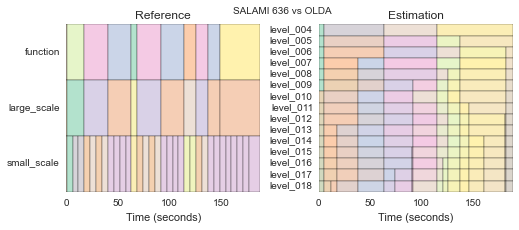

Window: +-0.50s
	Ref=T0, Est=T1: 0.2772
	Ref=T1, Est=T0: 0.5454
Window: +-3.00s
	Ref=T0, Est=T1: 0.3397
	Ref=T1, Est=T0: 0.7180
Window: +-5.00s
	Ref=T0, Est=T1: 0.3749
	Ref=T1, Est=T0: 0.7164
Window: +-10.00s
	Ref=T0, Est=T1: 0.5259
	Ref=T1, Est=T0: 0.7063
Window: +-15.00s
	Ref=T0, Est=T1: 0.6625
	Ref=T1, Est=T0: 0.7021
Window: +-30.00s
	Ref=T0, Est=T1: 0.7987
	Ref=T1, Est=T0: 0.5809
Window: +-45.00s
	Ref=T0, Est=T1: 0.8468
	Ref=T1, Est=T0: 0.5174
Window: +-0.00s
	Ref=T0, Est=T1: 0.9273
	Ref=T1, Est=T0: 0.4199


In [292]:
# Tree to tree, predicted
T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636_OLDA.jams", annotation_id=0)
# draw_tree(T1)
eval_trees(T0, T1, transitive=True, main_title="SALAMI 636 vs OLDA")

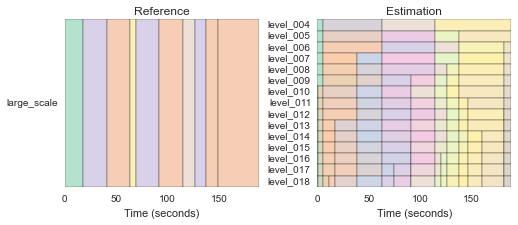

Window: +-0.50s
	Ref=T0, Est=T1: 0.5729
	Ref=T1, Est=T0: 0.3519
Window: +-3.00s
	Ref=T0, Est=T1: 0.6688
	Ref=T1, Est=T0: 0.4246
Window: +-5.00s
	Ref=T0, Est=T1: 0.7177
	Ref=T1, Est=T0: 0.4553
Window: +-10.00s
	Ref=T0, Est=T1: 0.7754
	Ref=T1, Est=T0: 0.5378
Window: +-15.00s
	Ref=T0, Est=T1: 0.8286
	Ref=T1, Est=T0: 0.5804
Window: +-30.00s
	Ref=T0, Est=T1: 0.8666
	Ref=T1, Est=T0: 0.5077
Window: +-45.00s
	Ref=T0, Est=T1: 0.8756
	Ref=T1, Est=T0: 0.4695
Window: +-0.00s
	Ref=T0, Est=T1: 0.9413
	Ref=T1, Est=T0: 0.4142


In [293]:
# Flat to tree, large scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636_OLDA.jams", annotation_id=0)

T0.collapse_to_level(level='large_scale')
T0.prune_to_level(level='large_scale')

# print T1

eval_trees(T0, T1, transitive=True)

In [ ]:
# Tree to tree

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)
eval_trees(T0, T1, transitive=True, main_title="SALAMI 636 Annotator 1 vs Annotator 2")

In [ ]:
# Flat to flat, large scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)


T0.prune_to_level(level='large_scale')
T1.prune_to_level(level='large_scale')
T0.collapse_to_level(level='large_scale')
T1.collapse_to_level(level='large_scale')

eval_trees(T0, T1, transitive=False)

In [ ]:
# Flat to flat, small scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)
T0.collapse_to_level(level='small_scale')
T1.collapse_to_level(level='small_scale')

eval_trees(T0, T1)

In [ ]:
# Flat to flat, large vs small scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)

T0.prune_to_level(level='large_scale')
T0.collapse_to_level(level='large_scale')
T1.collapse_to_level(level='small_scale')


eval_trees(T0, T1, transitive=False)

In [ ]:
# Flat to flat, large vs small scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)
T0.collapse_to_level(level='small_scale')
T1.prune_to_level(level='large_scale')
T1.collapse_to_level(level='large_scale')

eval_trees(T0, T1)

In [ ]:
# Tree to flat, small scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)
T1.collapse_to_level(level='small_scale')

eval_trees(T0, T1, transitive=False)

In [ ]:
# Tree to flat, large scale

T0 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=0)
T1 = tree.SegmentTree("test/SALAMI_636.jams", annotation_id=1)
T1.prune_to_level(level='large_scale')
T1.collapse_to_level(level='large_scale')

eval_trees(T0, T1)

In [ ]:
import mir_eval
import jams2

level = "large_scale"

bounds0, labels0 = jams2.converters.load_jams_range(
                            "test/SALAMI_636.jams", "sections", annotator=0, context=level)
bounds1, labels1 = jams2.converters.load_jams_range(
                            "test/SALAMI_636.jams", "sections", annotator=1, context=level)


P, R, F = mir_eval.boundary.detection(bounds0,
                                    bounds1, window=0.5, trim=True)
print "F-measure 0.5 seconds: Ref=A0, Est=A1:\n\tF=%.3f, P=%.3f, R=%.3f\n\tlevel: %s" % (F, P, R, level)


P, R, F = mir_eval.boundary.detection(bounds1,
                                    bounds0, window=0.5, trim=True)
print "F-measure 0.5 seconds: Ref=A1, Est=A0:\n\tF=%.3f, P=%.3f, R=%.3f\n\tlevel: %s" % (F, P, R, level)


R2E: 10.00, E2R: 0.00
57.1428571429 100.0 40.0


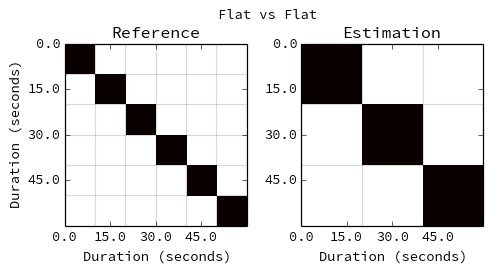

Window: +-0.50s
	Ref=T0, Est=T1: 0.4000
	Ref=T1, Est=T0: 1.0000
Window: +-3.00s
	Ref=T0, Est=T1: 0.4000
	Ref=T1, Est=T0: 1.0000
Window: +-5.00s
	Ref=T0, Est=T1: 0.4000
	Ref=T1, Est=T0: 1.0000
Window: +-10.00s
	Ref=T0, Est=T1: 0.3339
	Ref=T1, Est=T0: 0.6922
Window: +-15.00s
	Ref=T0, Est=T1: 0.3939
	Ref=T1, Est=T0: 0.5277
Window: +-30.00s
	Ref=T0, Est=T1: 0.6946
	Ref=T1, Est=T0: 0.4975
Window: +-45.00s
	Ref=T0, Est=T1: 0.7811
	Ref=T1, Est=T0: 0.4975
Window: +-0.00s
	Ref=T0, Est=T1: 0.8000> <ipython-input-115-759df0819be4>(65)tree_gauc()
-> import pdb; pdb.set_trace()
(Pdb) c
> <ipython-input-115-759df0819be4>(68)tree_gauc()
-> R = H_ref[q, max(0, q-window):min(n, q+window)]
(Pdb) c
> <ipython-input-115-759df0819be4>(65)tree_gauc()
-> import pdb; pdb.set_trace()
(Pdb) c
	Ref=T0, Est=T1: 0.3939
> <ipython-input-115-759df0819be4>(68)tree_gauc()
-> R = H_ref[q, max(0, q-window):min(n, q+window)]
(Pdb) print q
0
(Pdb) c
> <ipython-input-115-759df0819be4>(65)tree_gauc()
-> import pdb; pdb.set_

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [44]:
# Create Synthetic examples
import jams2
import json
import mir_eval

def create_jams(boundaries, out_file):
    jam = jams2.Jams()
    jam.metadata.duration = boundaries[0][-1]
    sections = jam.sections.create_annotation()
    for c, boundary_level in enumerate(boundaries):
        b_intervals = zip(boundary_level[:], boundary_level[1:])
        for b_interval in b_intervals:
            section = sections.create_datapoint()
            section.start.value = b_interval[0]
            section.end.value = b_interval[1]
            section.label.context = str(c)
    with open(out_file, "w") as f:
        json.dump(jam, f, indent=2)
        
def evaluate_flat(ref_times, est_times, w, trim=False):
    ref_times = np.asarray(ref_times).flatten()
    est_times = np.asarray(est_times).flatten()
    ref_inter = np.asarray(zip(ref_times[:], ref_times[1:]))
    est_inter = np.asarray(zip(est_times[:], est_times[1:]))
    p, r, f = mir_eval.boundary.detection(ref_inter, est_inter, trim=trim, window=w)
    R2E, E2R = mir_eval.boundary.deviation(ref_inter, est_inter, trim=trim)
    print "R2E: %.2f, E2R: %.2f" % (R2E, E2R)
    return f, p, r
    
def evaluate_bounds(bound1, bound2, main_title="", transitive=True):
    create_jams(bound1, "test/tmp1.jams")
    create_jams(bound2, "test/tmp2.jams")

    T0 = tree.SegmentTree("test/tmp1.jams", annotation_id=0)
    T1 = tree.SegmentTree("test/tmp2.jams", annotation_id=0)
    eval_trees(T0, T1, transitive=transitive, main_title=main_title)

# Flat vs flat

f1 = [[0, 10, 20, 30, 40, 50, 60]]
f2 = [[0, 20, 40, 60]]
trim = True
f, p, r = evaluate_flat(f1, f2, 3, trim=trim)
print f*100, p*100, r*100
evaluate_bounds(f1, f2, "Flat vs Flat"); plt.colorbar(), plt.show()


# Hierarchical vs Flat Large Scale
# h1 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60]]
# f2 = [[0, 20, 40, 60]]
# evaluate_bounds(h1, f2, main_title="Hierarchical vs Flat Large Scale"); show()

# Hierarchical vs Flat Small Scale
# h1 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60]]
# f2 = [[0, 10, 20, 30, 40, 50, 60]]
# evaluate_bounds(h1, f2, "Hierarchical vs Flat Small Scale"); show()

# Hierarchical vs Hierarchical
# h1 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60]]
# h2 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60]]
# evaluate_bounds(h1, h2, "Hierarchical vs Hierarchical"); show()

# Hierarchical vs 3-layer Hierarchical
# h1 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60]]
# h2 = [[0, 10, 20, 30, 40, 50, 60], [0, 20, 40, 60], [0, 40, 60]]
# evaluate_bounds(h1, h2, "2-Layer vs 3-Layer"); show()

# Figure 1 example of the paper
# h1 = [[0, 10, 20, 30], [0, 20, 30]]
# h2 = [[0, 10, 20, 30], [0, 10, 30]]
# evaluate_bounds(h1, h2, "Figure 1"); show()


In [34]:
T0 = tree.SegmentTree("test/tmp1.jams", annotation_id=0)
T1 = tree.SegmentTree("test/tmp2.jams", annotation_id=0)

In [36]:
import librosa

<matplotlib.colorbar.Colorbar instance at 0x3ee63f8>

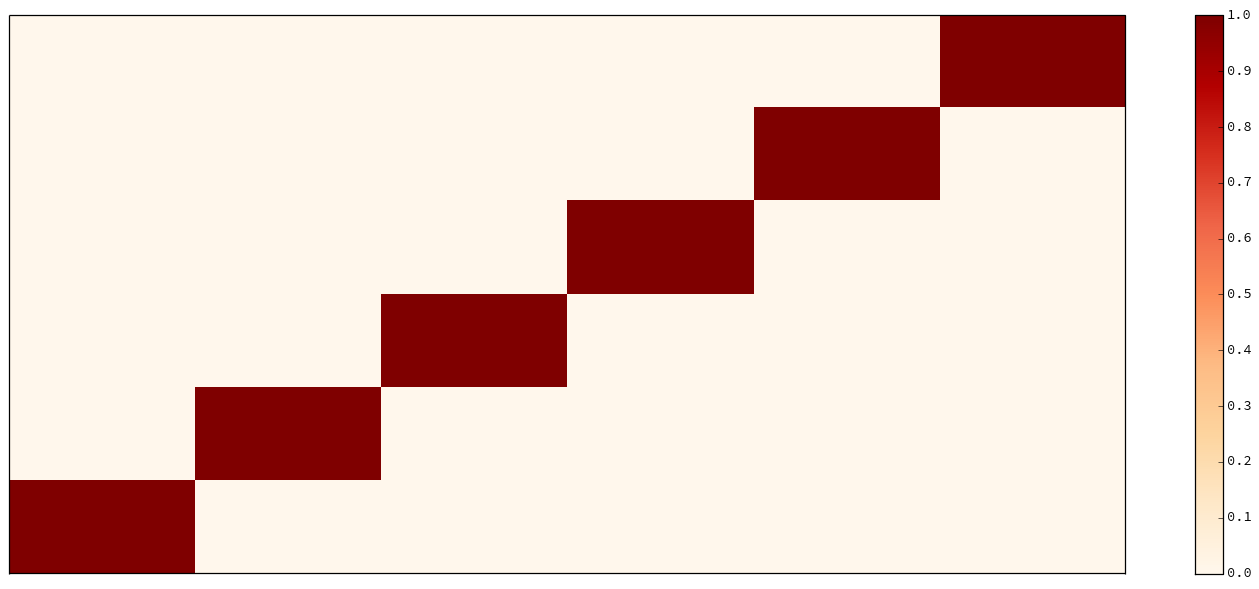

In [37]:
librosa.display.specshow(lca_matrix(T0))
plt.colorbar()
#print lca_matrix(T1)